In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

100%|██████████| 25/25 [00:05<00:00,  4.56it/s]


<Figure size 640x480 with 0 Axes>

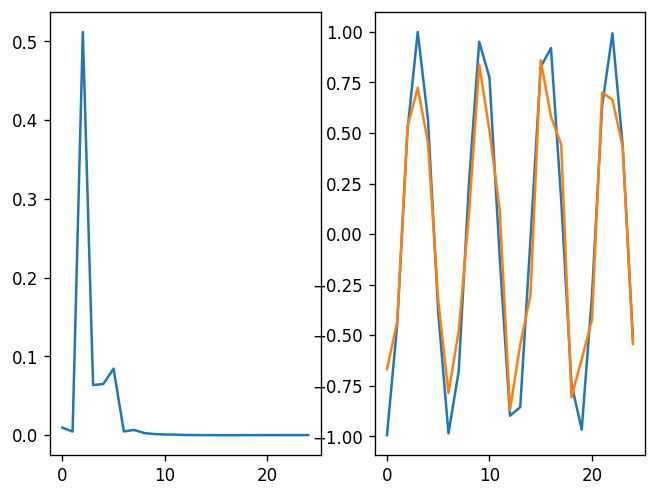

In [2]:
def dataset(size =  200, timesteps = 25):
    x, y = [], []
    sin_wave = np.sin(np.arange(size))
    for step in range(sin_wave.shape[0]-timesteps):
        x.append(sin_wave[step:step+timesteps])
        y.append(sin_wave[step+timesteps])
    return np.array(x).reshape(len(y),timesteps,1),np.array(y).reshape(len(y),1)

class RNN:
    def __init__(self, x, y, hidden_units):
        self.x = x
        self.y = y
        self.hidden_units = hidden_units
        self.Wx = np.random.randn(self.hidden_units, self.x.shape[2])
        self.Wh = np.random.randn(self.hidden_units, self.hidden_units)
        self.Wy = np.random.randn(self.y.shape[1],self.hidden_units)

    def cell(self, xt, ht_1):
        ht = np.tanh(np.dot(self.Wx,xt.reshape(1,1)) + np.dot(self.Wh,ht_1))
        yt = np.dot(self.Wy,ht)
        return ht, yt

    def forward(self, sample):
        sample_x, sample_y = self.x[sample], self.y[sample]
        ht = np.zeros((self.hidden_units,1))
        self.hidden_states = [ht]
        self.inputs = []
        for step in range(len(sample_x)):
            ht, yt = self.cell(sample_x[step],ht)
            self.inputs.append(sample_x[step].reshape(1,1))
            self.hidden_states.append(ht)
        self.error = yt - sample_y
        self.loss = 0.5*self.error**2
        self.yt = yt


    def backward(self):
        n = len(self.inputs)
        dyt = self.error
        dWy = np.dot(dyt,self.hidden_states[-1].T)
        dht = np.dot(dyt, self.Wy).T
        dWx = np.zeros(self.Wx.shape)
        dWh = np.zeros(self.Wh.shape)

        for step in reversed(range(n)):
            temp = (1-self.hidden_states[step+1]**2) * dht
            dWx += np.dot(temp, self.inputs[step].T)
            dWh += np.dot(temp, self.hidden_states[step].T)

            dht = np.dot(self.Wh, temp)
        dWy = np.clip(dWy, -1, 1)
        dWx = np.clip(dWx, -1, 1)
        dWh = np.clip(dWh, -1, 1)
        self.Wy -= self.lr * dWy
        self.Wx -= self.lr * dWx
        self.Wh -= self.lr * dWh

    def train(self, epochs, learning_rate):
        self.Ovr_loss = []
        self.lr = learning_rate
        for epoch in tqdm(range(epochs)):
            for sample in range(self.x.shape[0]):
                self.forward(sample)
                self.backward()
            self.Ovr_loss.append(np.squeeze(self.loss / self.x.shape[0]))
            self.loss = 0



    def test(self,x,y):
        self.x = x
        self.y = y
        self.outputs = []
        for sample in range(len(x)):
            self.forward(sample)
            self.outputs.append(self.yt)

x,y = dataset()
x_test, y_test = dataset(300)
x_test = x_test[250:]
y_test = y_test[250:]
rnn = RNN(x,y,100)
rnn.train(25,1e-2)
rnn.test(x_test, y_test)
plt.tight_layout()
plt.figure(dpi=120)
plt.subplot(121)
plt.plot(rnn.Ovr_loss)
plt.subplot(122)
plt.plot([i for i in range(len(x_test))],y_test,np.array(rnn.outputs).reshape(y_test.shape))